# Water Quality

## This notebook is currently under development!

## Notebook Summary
 



### Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
#from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic
from datacube_utilities.createAOI import create_lat_lon
#from datacube_utilities.clean_mask import landsat_qa_clean_mask
#from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
#from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask

## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
#set baseline start and end of period
baseline_start_date = '2019-1-1'
baseline_end_date = '2019-3-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
platform = "LANDSAT_8"
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:32760"

## Translate inputs

In [5]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)


In [6]:
#create resolution
resolution = (-res, res)

In [7]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [8]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [11]:
product, measurement, water_product = create_product_measurement(platform)

## Load Data 

In [12]:
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'dask_chunks': dask_chunks
}

In [13]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)

In [14]:
print(ds)

<xarray.Dataset>
Dimensions:   (time: 11, x: 213, y: 261)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-06T22:00:18 ... 2019-03-27T22:00:00
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    green     (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    red       (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    blue      (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    nir       (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    swir1     (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    swir2     (time, y, x) int16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
Attributes:
    crs:      EPSG:32760


In [15]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


## Load Water Masks

## Mask cloud

In [16]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [17]:
good_quality = look_up_clean(platform, ds)

In [18]:
print(good_quality)

<xarray.DataArray 'pixel_qa' (time: 11, y: 261, x: 213)>
dask.array<shape=(11, 261, 213), dtype=bool, chunksize=(1, 261, 213)>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-06T22:00:18 ... 2019-03-27T22:00:00
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


In [19]:
ds_clear = ds.where(good_quality)

In [20]:
print(ds_clear)

<xarray.Dataset>
Dimensions:   (time: 11, x: 213, y: 261)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-06T22:00:18 ... 2019-03-27T22:00:00
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    green     (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    red       (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    blue      (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    nir       (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    swir1     (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    swir2     (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
    pixel_qa  (time, y, x) float64 dask.array<shape=(11, 261, 213), chunksize=(1, 261, 213)>
Attributes:
    crs:    

In [21]:
#when S2 mask is ready - can remove the if statement. 
if platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes = dc.load(product=water_product,
              measurements = ["water_classification"],
               **query)
    #change clouds to no data value
    water_classes = water_scenes.where(water_scenes >= 0)
elif platform in ["SENTINEL_2"]:
    water_classes = dask.delayed(wofs_classify)(ds, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes = dask.delayed(water_classes.rename({'wofs': 'water_classification'}))
          

In [22]:
water_dataset = water_classes.where(water_classes == 1)

In [46]:
water_dataset2 = water_dataset.compute()

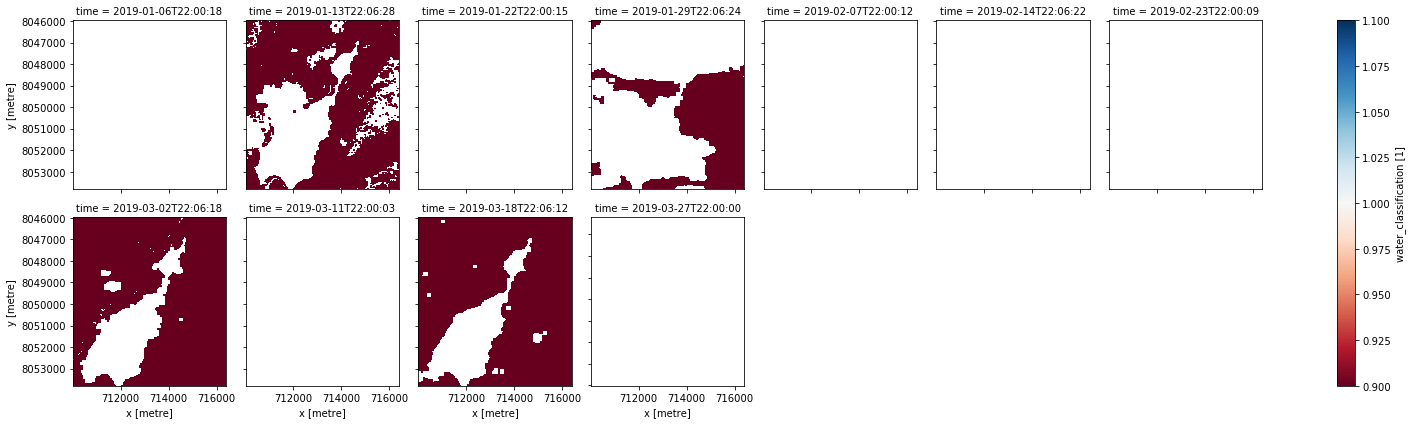

In [47]:
water_dataset2.water_classification.plot(cmap="RdBu", robust=True, col="time", col_wrap=7)
plt.show()

In [60]:
test = xr.Dataset.to_array(water_dataset2)

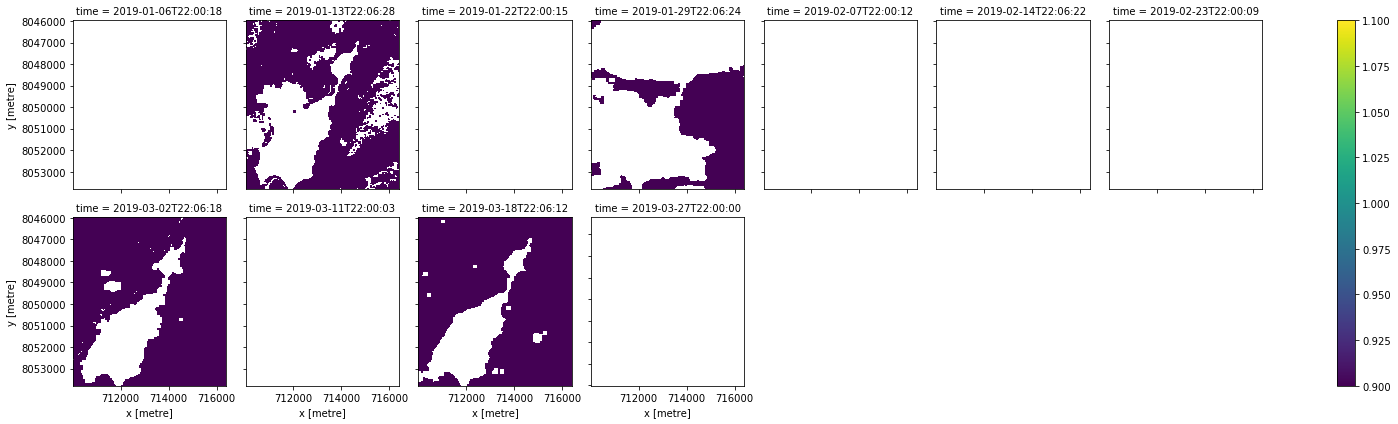

In [61]:
test.plot(robust=True, col="time", col_wrap=7)
plt.show()

In [67]:
test2 = ds_clear.where(test > 0)

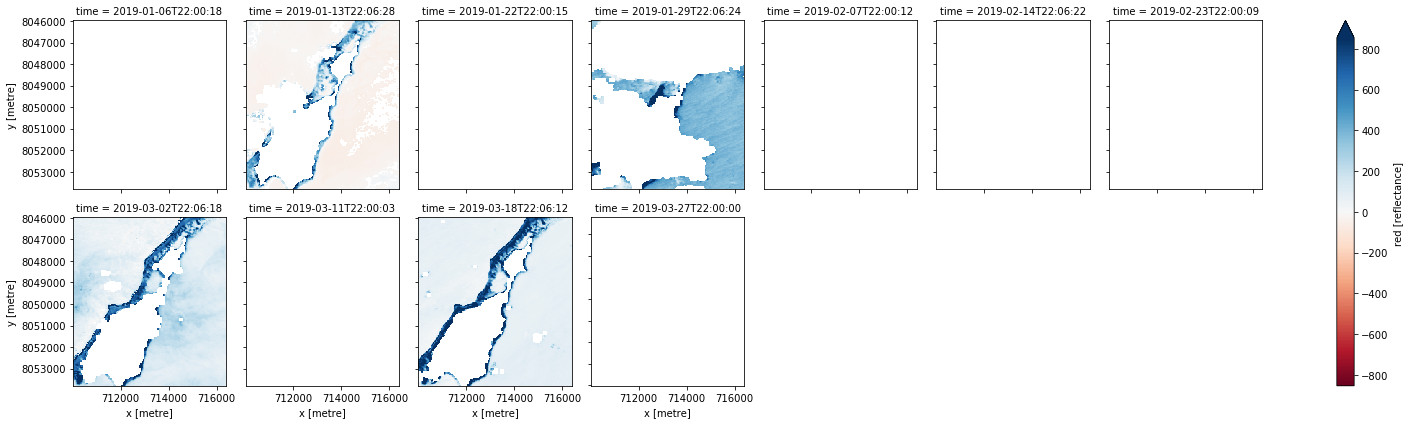

In [68]:
test2.red.plot(cmap="RdBu", robust=True, col="time", col_wrap=7)
plt.show()

In [64]:
from datacube_utilities.dc_water_quality import tsm

In [69]:
tsm_dataset = tsm(test2)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)


In [70]:
print(tsm_dataset)

<xarray.Dataset>
Dimensions:   (time: 11, variable: 1, x: 213, y: 261)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-06T22:00:18 ... 2019-03-27T22:00:00
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
  * variable  (variable) <U20 'water_classification'
Data variables:
    tsm       (time, y, x, variable) float64 dask.array<shape=(11, 261, 213, 1), chunksize=(1, 261, 213, 1)>


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)


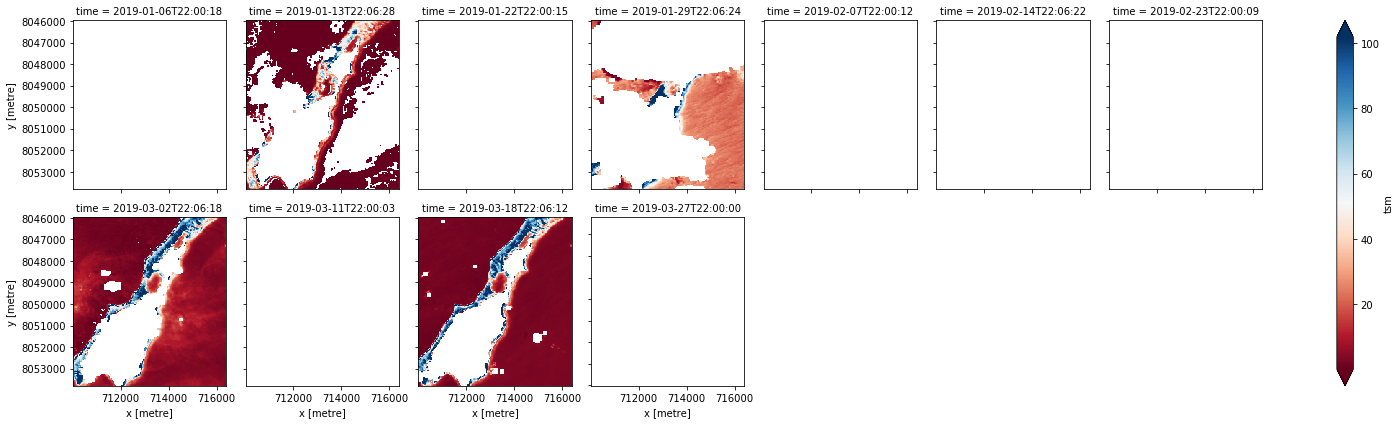

In [71]:
tsm_dataset.tsm.plot(cmap="RdBu", robust=True, col="time", col_wrap=7)
plt.show()

## plot mean tsm

In [72]:
mean_tsm = tsm_dataset.mean(dim=['time'])

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


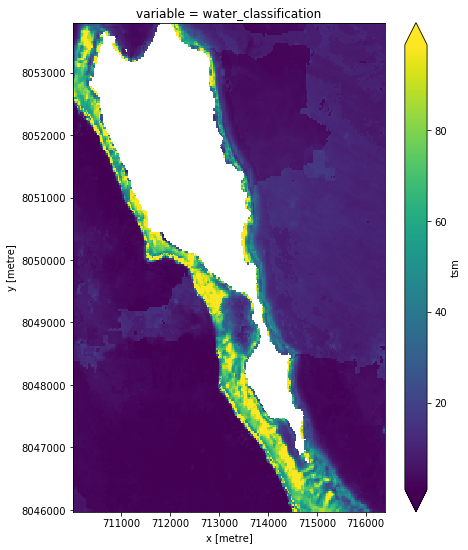

In [75]:
fig = plt.figure(figsize=(7, 9))
mean_tsm.tsm.plot(robust=True)

## plot max tsm

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


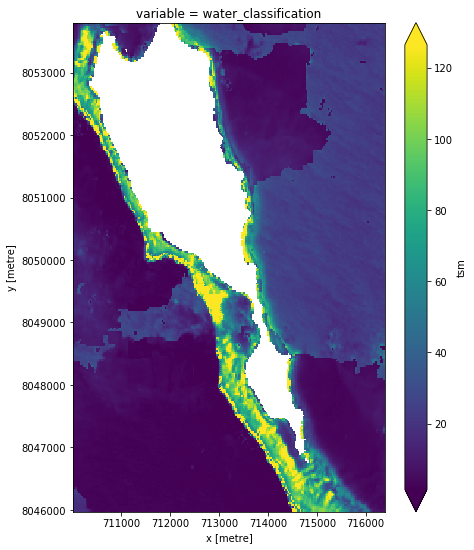

In [76]:
max_tsm = tsm_dataset.max(dim=['time'])
fig = plt.figure(figsize=(7, 9))
max_tsm.tsm.plot(robust=True)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in power
  return func(*args2)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


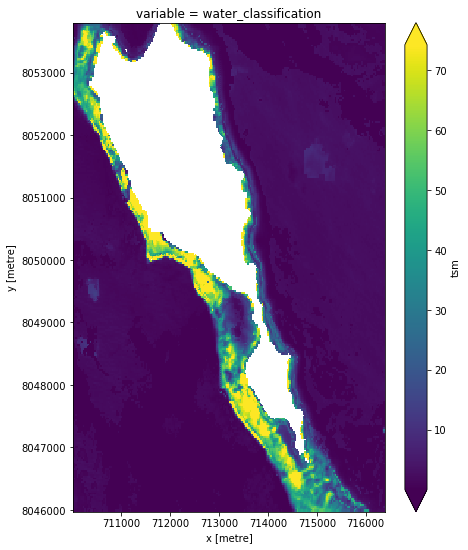

In [78]:
min_tsm = tsm_dataset.min(dim=['time'])
fig = plt.figure(figsize=(7, 9))
min_tsm.tsm.plot(robust=True)

## Exports

In [88]:
#####STILL NEED TO FIGURE OUT EXPORTS
#mean_tsm_output = xr.Dataset.to_array(mean_tsm)
tes = xr.Dataset.to_array(mean_tsm)
#print(mean_tsm)
print(test)

<xarray.DataArray 'stack-accdf6af24914cf35ae836bb3e39f172' (variable: 1, y: 261, x: 213)>
dask.array<shape=(1, 261, 213, 1), dtype=float64, chunksize=(1, 261, 213, 1)>
Coordinates:
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
  * variable  (variable) <U3 'tsm'


In [89]:
write_geotiff_from_xr('mean_tsm.tiff', tes.tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')

AttributeError: 'DataArray' object has no attribute 'tsm'

---